# 1 Electric Load Forecasting for Texas Weather Zones

## 1.1 Introduction

Electric load forecasting is the prediction of electrical power required to meet the short term, medium term or long term demand. The forecasting helps the utility companies in their operation and management of the supply to their customers. So, it is very important for utility companies to have a reliable and accurate load forecasting models to allocate appropriate resources to meet the demand from consumers.

Recently Texas have seen wide spread power outages as a result of extreme weather conditions (severe freezing as well as hot summer days). During such events, the utility companies have asked residents to limit their electric usage to avoid outage. A model that forecasts energy demand accurately would be very helpful to avoid wide spread power outage instead of waiting for consumers to limit their usage. **The main objective of this project would be to build a robust model that predict hourly electric load in each weather zone in Texas (see image below) in the short term (the next 7 days).**


The project will be sub-divided into several notebooks as follows:
- **Data Wrangling**
- **Exploratory Data Analysis (EDA)**
- **Pre-processing and Training and**
- **Modeling**




<img src = "./raw_data/ercotWeatherZoneMap.png" alt="drawing" width="500"/>


## 1.2 Contents
1.  [Electric Load Forecasting for Texas Weather Zones](#1-Electric-Load-Forecasting-for-Texas-Weather-Zones)  
   * 1.1  [Introduction](#1.1-Introduction)  
   * 1.2  [Contents](#1.2-Contents)  
   * 1.3  [Data Wrangling](#1.2-Data-Wrangling) 
        * 1.3.1 [Import Libraries](#1.3.1-Import-Libraries)  
        * 1.3.2 [Load The Hourly Electric Load](#1.3.2-Load-The-Hourly-Electric-Load)  
            * 1.3.2.1 [Exploring The Electric Load Data](#1.3.2.1-Exploring-The-Electric-Load-Data)
            * 1.3.2.2 [Summary Statistics and Visualization](#1.3.2.2-Summary-Statistics-and-Visualization)
            * 1.3.2.3 [Feature Extraction](#1.3.2.3-Feature-Extraction)
        * 1.3.3 [Load The Weather data](#1.3.3-Load-The-Weather-data)
            * 1.3.3.1 [Exploring The Weather Data](#1.3.3.1-Exploring-The-Weather-Data)
            * 1.3.3.2 [Data Visualization](#1.3.3.2-Data-Visualization)
            * 1.3.3.3 [Selecting One City For Each Zone](#1.3.3.3-Selecting-One-City-For-Each-Zone)
        * 1.3.4 [Load The Covid19 Datasets](#1.3.4-Load-The-Covid19-Datasets)
            * 1.3.4.1 [Renaming and Merging Covid19 Datasets](#1.3.4.1-Renaming-and-Merging-Covid19-Datasets)
        * 1.3.5 [Saving Cleaned Data](#1.3.5-Saving-Cleaned-Data)
        * 1.3.6 [Summary](#1.3.6-Summary)




            


            


## 1.3 Data Wrangling

This is the first part of the several notebooks to be written for this project. Data Wrangling section will involve read the raw data and prepare it for preprocessing and analysis. We have three different kind of datasets. These include:
- The hourly electric consumption for each of the 8 weather zones in Texas. The dataset is downloaded from the Electric Reliability Council of Texas (ERCOT) website. 
- Historic weather data and forecasted weather data (data is from https://api.worldweatheronline.com/premium/v1/weather.ashx)
- Texas Covid19 confirmed cases and Covid19 related deaths (data is downloaded from Jhon Hopkins University Repository

The above datasets were also provided in https://www.kaggle.com/c/wids-texas-datathon-2021/data as part of Kaggle competition.


In this notebook we will read and explore each of the above datasets, excpet the weather forsecast data (this data is not need this data until the final model is ready for forecasting). The datasets will be checked for any missing value,inconsistency. We will generate summary statistics, perform some visualization and do preliminary exploratory data analysis.

## 1.3.1 Import Libraries


In [29]:
# Import relevant libraries
import os, types
import io, requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import datetime as dt
from pandas.tseries.holiday import USFederalHolidayCalendar as cal
from pandas.tseries.offsets import CustomBusinessDay, BDay

## 1.3.2 Load The Hourly Electric Load

In [30]:
## Loading The hourly load 
url = 'https://raw.githubusercontent.com/WiDSTexas2021/datathon-code/main/data/ercot_hourly_load.csv'
s = requests.get(url).content
hr_load_raw = pd.read_csv(io.StringIO(s.decode('utf-8')))
hr_load_raw.head()

Hour_Ending        Coast        East    Far West       North  \
0  2005-01-01 01:00:00-06:00  7507.810731  850.313988  998.465500  741.963778   
1  2005-01-01 02:00:00-06:00  7257.549136  818.143264  987.532852  711.996586   
2  2005-01-01 03:00:00-06:00  6973.987199  783.396624  978.575662  687.881144   
3  2005-01-01 04:00:00-06:00  6794.489296  760.639635  959.486947  673.419383   
4  2005-01-01 05:00:00-06:00  6685.186677  743.371691  955.268590  664.792118   

   North Central        South  South Central        West  
0    7312.259820  1883.979457    3728.400885  692.294503  
1    7012.466197  1798.234153    3562.614723  675.176013  
2    6712.807281  1712.758395    3373.868049  659.650453  
3    6502.378446  1651.210254    3239.047417  648.512894  
4    6440.559639  1627.872766    3176.859720  647.001780

In [31]:
hr_load_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144335 entries, 0 to 144334
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Hour_Ending    144335 non-null  object 
 1   Coast          144334 non-null  float64
 2   East           144334 non-null  float64
 3   Far West       144334 non-null  float64
 4   North          144334 non-null  float64
 5   North Central  144334 non-null  float64
 6   South          144334 non-null  float64
 7   South Central  144334 non-null  float64
 8   West           144334 non-null  float64
dtypes: float64(8), object(1)
memory usage: 9.9+ MB


### 1.3.2.1 Exploring The Electric Load Data
In this section we will explore the dataset indetail. 

   - Check if there are any missing values. Based on the size and kind of the missing data, we will decided wether to fill or drop the missing values
   - Make sure the column names are descriptive
   - Since this is a time series data, the date attribute needs to be in datetime format. 
<p>&nbsp;</p> 

In [32]:
# rename the column Hour_ending to Date to make more descriptive
hr_load_raw.rename(columns={'Hour_Ending':'Date'}, inplace=True)

In [33]:
hr_load_raw.isnull().sum()

Date             0
Coast            1
East             1
Far West         1
North            1
North Central    1
South            1
South Central    1
West             1
dtype: int64

In [34]:
hr_load_raw[hr_load_raw.isnull().any(axis = 1)]

Date  Coast  East  Far West  North  \
103871  2016-11-07 00:00:00-06:00    NaN   NaN       NaN    NaN   

        North Central  South  South Central  West  
103871            NaN    NaN            NaN   NaN

- Out of the 144335 raws only one raw has null values and it can be easily interpolated using fill method

In [35]:
hr_load_raw = hr_load_raw.fillna(method = 'bfill')
hr_load_raw.isnull().sum()

Date             0
Coast            0
East             0
Far West         0
North            0
North Central    0
South            0
South Central    0
West             0
dtype: int64

In [36]:
hr_load_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144335 entries, 0 to 144334
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           144335 non-null  object 
 1   Coast          144335 non-null  float64
 2   East           144335 non-null  float64
 3   Far West       144335 non-null  float64
 4   North          144335 non-null  float64
 5   North Central  144335 non-null  float64
 6   South          144335 non-null  float64
 7   South Central  144335 non-null  float64
 8   West           144335 non-null  float64
dtypes: float64(8), object(1)
memory usage: 9.9+ MB


In [37]:
# Convert the date to datetime64[ns] format and make the data as the index of the dataframe
hr_load_raw['Date'] = hr_load_raw['Date'].apply(lambda x : pd.to_datetime(x[:-6]))
hr_load_raw.set_index('Date', inplace=True)
hr_load_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144335 entries, 2005-01-01 01:00:00 to 2021-06-20 00:00:00
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Coast          144335 non-null  float64
 1   East           144335 non-null  float64
 2   Far West       144335 non-null  float64
 3   North          144335 non-null  float64
 4   North Central  144335 non-null  float64
 5   South          144335 non-null  float64
 6   South Central  144335 non-null  float64
 7   West           144335 non-null  float64
dtypes: float64(8)
memory usage: 9.9 MB


### 1.3.2.2 Summary Statistics and Visualization
It is always advisable to have the overall picture of the data. Hence we will extract the statistical summary and do some visualization. We will also plot the actual electric load for each region to see if there is any seasonality and trend on it. The plots can give hint if the time series is stationary or non-stationary
<p>&nbsp;</p>

In [38]:
# Get the summary statistics
hr_load_raw.describe()

Coast           East       Far West          North  \
count  144335.000000  144335.000000  144335.000000  144335.000000   
mean    11024.728910    1409.512280    1960.107904     914.599510   
std      2643.100195     335.217675     863.032015     257.793510   
min      1702.829343     737.857378     872.014264     488.272293   
25%      9126.126681    1175.760745    1260.115981     730.887486   
50%     10473.205120    1337.712819    1662.947000     846.833315   
75%     12477.727012    1591.470520    2405.729846    1038.589489   
max     21256.115190    2949.198517    4636.980000    2305.722761   

       North Central          South  South Central           West  
count  144335.000000  144335.000000  144335.000000  144335.000000  
mean    12646.403931    3067.267544    6316.374140    1083.917456  
std      3495.326432     842.428726    1726.869975     253.802416  
min      6211.523935    1351.410393    3055.595655     571.771569  
25%     10237.891244    2438.678585    5105.047427     900.296749  
50%     11805.151459    2922.887596    5910.689371    1041.475773  
75%     14429.705038    3561.849403    7232.542342    1223.922705  
max     26499.240955    6192.252947   14166.701623    3751.210350

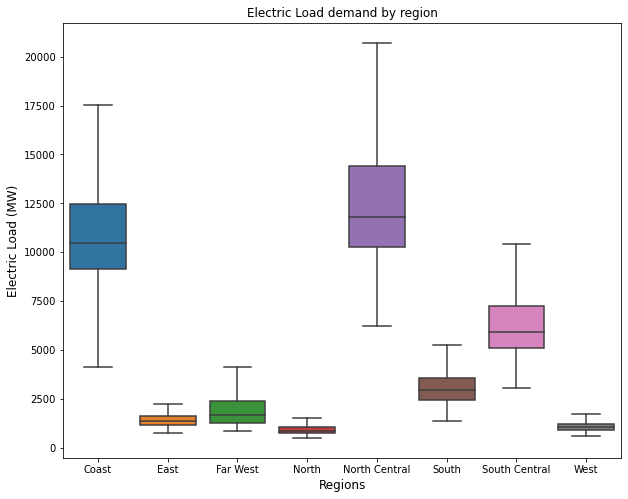

In [39]:
# Making a boxplot to see the statistical summary visually
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(data = hr_load_raw, showfliers = False) # by ignoring outliers
plt.xlabel('Regions', fontsize = 12)
plt.ylabel('Electric Load (MW)', fontsize = 12)
plt.title('Electric Load demand by region')
plt.show()

By far the North Central and the Coast zones account the majority of the electric load demand, followed by the South Central and South zones. This is not surprising, as the North Central and the Coast have the two largest metropolitan areas of Dallas-Fort Worth and Houston respectively. South West zone also includes the cities of Austin and San-Antonio.

This summary statistics shows, the electric load demand is proportional to the population size.
<p>&nbsp;</p>

Next we will write a funcation to plot the electric load data

In [40]:
# Plotting the actual hourly load

def load_plot(df, start_time = None, end_time = None):
    """ This function plots all the columns of the dataframe
    
        df - name of the dataframe
        start_time - the time stamp where you start the plot
        end_time - the time stamp where you end the plot
        start_time and end_time must be a string format"""

    if start_time != None:
        if (type(start_time) or type(end_time)) != str:
           raise Exception('start_time or end_time is not a string')
    
    ax_column = df.columns
    fig, ax = plt.subplots(8,1, figsize = (15,20))
    plt.subplots_adjust(hspace= 1.0)
    for i, zone in enumerate(ax_column):
        ax[i].plot(df[zone][start_time : end_time]) 
        ax[i].set_xlabel(zone, fontsize=12)
        ax[i].set_ylabel('Load (MW)', fontsize=12)
    return ax[i]

<AxesSubplot:xlabel='West', ylabel='Load (MW)'>

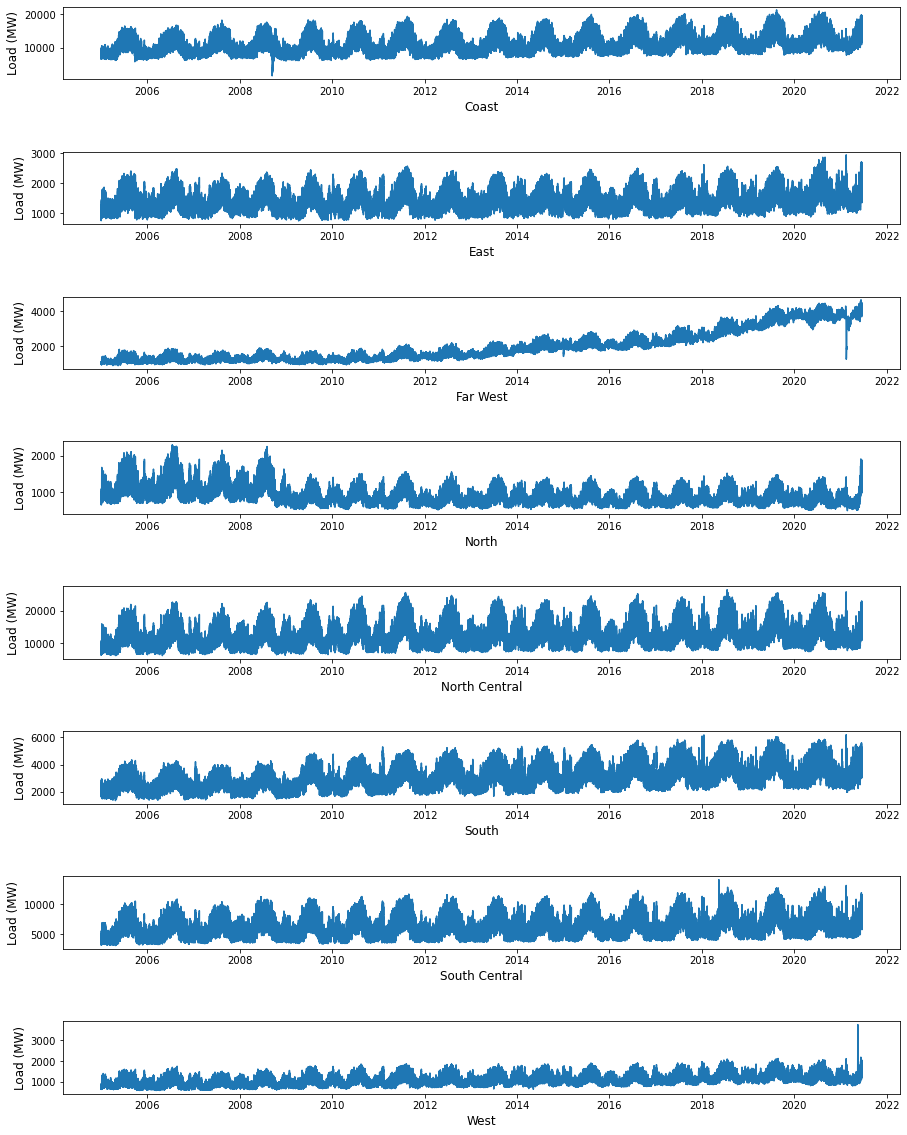

In [41]:
# plot the entire dataframe
load_plot(hr_load_raw)

- The electric load demand shows strong seasonality in all zones. 
- There is a strong upward trend in the farwest zone. This strong upward trend is not observed in the other zones(eventough a very small upward trend can be infered)

<AxesSubplot:xlabel='West', ylabel='Load (MW)'>

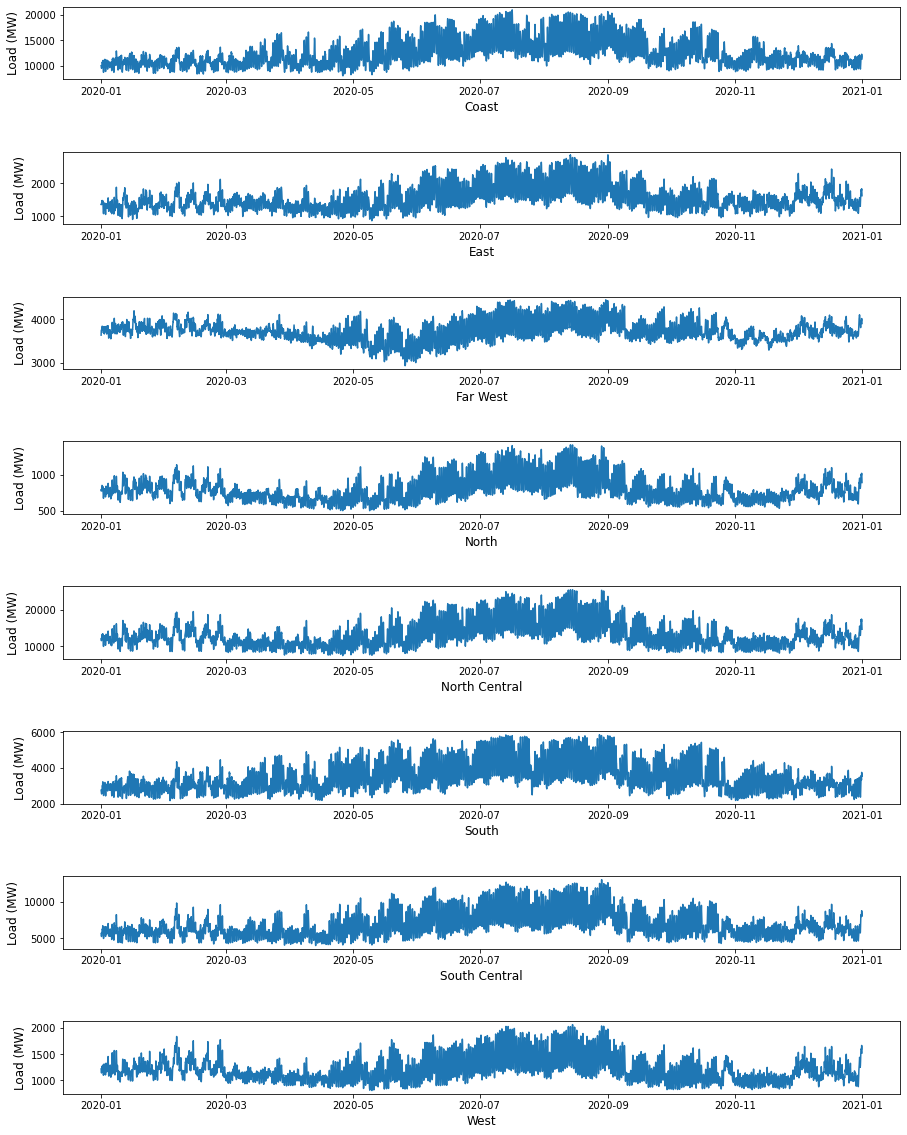

In [42]:
# Plot a subset of the load demand e.g just for year 2020
load_plot(hr_load_raw,'2020-01-01' , '2020-12-31')

<AxesSubplot:xlabel='West', ylabel='Load (MW)'>

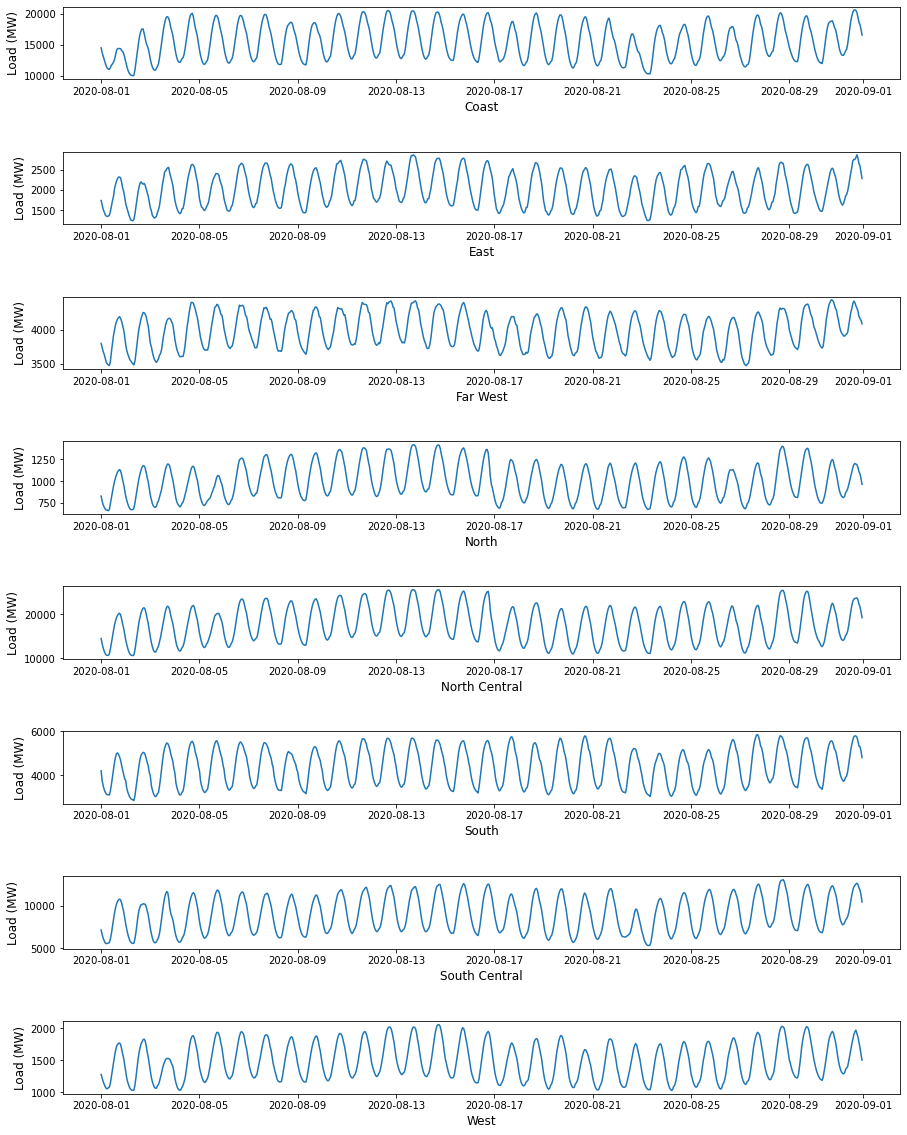

In [43]:
# Plot a subset of the load demand e.g the month of August 2020
load_plot(hr_load_raw,'2020-08-01','2020-08-31')

In [44]:
# Plot a subset of the load demand e.g The first week of August 2020
#load_plot(hr_load_raw,'2020-08-01','2020-08-08')


- Seasonality is also present on daily and monthly basis. There is huge demand during the afternoon hours and lower during the night. Similarly, strong demand is observed in the summer months compared

### 1.3.2.3 Feature Extraction


Extracting new features from the Date information.
  
- Extract several features such as weekdays,month,year,etc from the datetime stamp in the data
- Add a category classifying each day as a working or non-working day
- Add a column indicating if a given day is a holiday or not (based on the US government holiday calander)
- Finally we will covert the boolean values  of the holiday and working day columns to 0 and 1 values
<p>&nbsp;</p>

In [45]:
# Copy the hourly dataframe into a new dataframe. 
hr_load = hr_load_raw.copy()
hr_load.head()

Coast        East    Far West       North  \
Date                                                                   
2005-01-01 01:00:00  7507.810731  850.313988  998.465500  741.963778   
2005-01-01 02:00:00  7257.549136  818.143264  987.532852  711.996586   
2005-01-01 03:00:00  6973.987199  783.396624  978.575662  687.881144   
2005-01-01 04:00:00  6794.489296  760.639635  959.486947  673.419383   
2005-01-01 05:00:00  6685.186677  743.371691  955.268590  664.792118   

                     North Central        South  South Central        West  
Date                                                                        
2005-01-01 01:00:00    7312.259820  1883.979457    3728.400885  692.294503  
2005-01-01 02:00:00    7012.466197  1798.234153    3562.614723  675.176013  
2005-01-01 03:00:00    6712.807281  1712.758395    3373.868049  659.650453  
2005-01-01 04:00:00    6502.378446  1651.210254    3239.047417  648.512894  
2005-01-01 05:00:00    6440.559639  1627.872766    3176.859720  647.001780

In [46]:
# Extracting features from the datetime stamp
hr_load['dates'] = hr_load.index.date
hr_load['dates'] = pd.to_datetime(hr_load['dates'])
hr_load['hour'] = hr_load.index.hour
hr_load['day'] = hr_load.index.day
hr_load['month'] = hr_load.index.month
hr_load['year'] = hr_load.index.year
hr_load['weekday'] = hr_load.index.weekday
hr_load.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144335 entries, 2005-01-01 01:00:00 to 2021-06-20 00:00:00
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Coast          144335 non-null  float64       
 1   East           144335 non-null  float64       
 2   Far West       144335 non-null  float64       
 3   North          144335 non-null  float64       
 4   North Central  144335 non-null  float64       
 5   South          144335 non-null  float64       
 6   South Central  144335 non-null  float64       
 7   West           144335 non-null  float64       
 8   dates          144335 non-null  datetime64[ns]
 9   hour           144335 non-null  int64         
 10  day            144335 non-null  int64         
 11  month          144335 non-null  int64         
 12  year           144335 non-null  int64         
 13  weekday        144335 non-null  int64         
dtypes: datetime64[ns](

The output of weekday is alpha-numeric instead of the actual day name. In the next line of codes we will:
- Update the alpha-numeric weekday to its corresponding day name
- Create columns for holiday and working_day


In [47]:
# Convert the numeric weekday to its corresponding day name
hr_load['weekday'] = hr_load['dates'].dt.strftime('%A')

holidays = cal().holidays(hr_load['dates'].dt.date.min(),hr_load['dates'].dt.date.max())
hr_load['holiday'] = hr_load['dates'].isin(holidays) 

# Extract the US buisiness days (working days). Thsi excludes weekends and holidays
us_bd = CustomBusinessDay(calendar=cal()) 
working_days = pd.date_range(hr_load['dates'].dt.date.min(),hr_load['dates'].dt.date.max(), freq=us_bd)
hr_load['working_day'] = hr_load['dates'].isin(working_days)


In [48]:
hr_load.head()

Coast        East    Far West       North  \
Date                                                                   
2005-01-01 01:00:00  7507.810731  850.313988  998.465500  741.963778   
2005-01-01 02:00:00  7257.549136  818.143264  987.532852  711.996586   
2005-01-01 03:00:00  6973.987199  783.396624  978.575662  687.881144   
2005-01-01 04:00:00  6794.489296  760.639635  959.486947  673.419383   
2005-01-01 05:00:00  6685.186677  743.371691  955.268590  664.792118   

                     North Central        South  South Central        West  \
Date                                                                         
2005-01-01 01:00:00    7312.259820  1883.979457    3728.400885  692.294503   
2005-01-01 02:00:00    7012.466197  1798.234153    3562.614723  675.176013   
2005-01-01 03:00:00    6712.807281  1712.758395    3373.868049  659.650453   
2005-01-01 04:00:00    6502.378446  1651.210254    3239.047417  648.512894   
2005-01-01 05:00:00    6440.559639  1627.872766    3176.859720  647.001780   

                         dates  hour  day  month  year   weekday  holiday  \
Date                                                                        
2005-01-01 01:00:00 2005-01-01     1    1      1  2005  Saturday    False   
2005-01-01 02:00:00 2005-01-01     2    1      1  2005  Saturday    False   
2005-01-01 03:00:00 2005-01-01     3    1      1  2005  Saturday    False   
2005-01-01 04:00:00 2005-01-01     4    1      1  2005  Saturday    False   
2005-01-01 05:00:00 2005-01-01     5    1      1  2005  Saturday    False   

                     working_day  
Date                              
2005-01-01 01:00:00        False  
2005-01-01 02:00:00        False  
2005-01-01 03:00:00        False  
2005-01-01 04:00:00        False  
2005-01-01 05:00:00        False

In [49]:
# Map the boolian values of the holiday and working colummns into 0 and 1.
# 1 means it is a holiday and a working day will be 1
mapper = {True:1,False:0}
hr_load.holiday = hr_load.holiday.map(mapper)
hr_load.working_day = hr_load.working_day.map(mapper)

In [50]:
hr_load.head()

Coast        East    Far West       North  \
Date                                                                   
2005-01-01 01:00:00  7507.810731  850.313988  998.465500  741.963778   
2005-01-01 02:00:00  7257.549136  818.143264  987.532852  711.996586   
2005-01-01 03:00:00  6973.987199  783.396624  978.575662  687.881144   
2005-01-01 04:00:00  6794.489296  760.639635  959.486947  673.419383   
2005-01-01 05:00:00  6685.186677  743.371691  955.268590  664.792118   

                     North Central        South  South Central        West  \
Date                                                                         
2005-01-01 01:00:00    7312.259820  1883.979457    3728.400885  692.294503   
2005-01-01 02:00:00    7012.466197  1798.234153    3562.614723  675.176013   
2005-01-01 03:00:00    6712.807281  1712.758395    3373.868049  659.650453   
2005-01-01 04:00:00    6502.378446  1651.210254    3239.047417  648.512894   
2005-01-01 05:00:00    6440.559639  1627.872766    3176.859720  647.001780   

                         dates  hour  day  month  year   weekday  holiday  \
Date                                                                        
2005-01-01 01:00:00 2005-01-01     1    1      1  2005  Saturday        0   
2005-01-01 02:00:00 2005-01-01     2    1      1  2005  Saturday        0   
2005-01-01 03:00:00 2005-01-01     3    1      1  2005  Saturday        0   
2005-01-01 04:00:00 2005-01-01     4    1      1  2005  Saturday        0   
2005-01-01 05:00:00 2005-01-01     5    1      1  2005  Saturday        0   

                     working_day  
Date                              
2005-01-01 01:00:00            0  
2005-01-01 02:00:00            0  
2005-01-01 03:00:00            0  
2005-01-01 04:00:00            0  
2005-01-01 05:00:00            0

In [51]:
hr_load.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144335 entries, 2005-01-01 01:00:00 to 2021-06-20 00:00:00
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Coast          144335 non-null  float64       
 1   East           144335 non-null  float64       
 2   Far West       144335 non-null  float64       
 3   North          144335 non-null  float64       
 4   North Central  144335 non-null  float64       
 5   South          144335 non-null  float64       
 6   South Central  144335 non-null  float64       
 7   West           144335 non-null  float64       
 8   dates          144335 non-null  datetime64[ns]
 9   hour           144335 non-null  int64         
 10  day            144335 non-null  int64         
 11  month          144335 non-null  int64         
 12  year           144335 non-null  int64         
 13  weekday        144335 non-null  object        
 14  holiday        144

In [52]:
# Convert the weekday into a categorical object
from pandas.api.types import CategoricalDtype
dayname = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=dayname, ordered=True)
hr_load.weekday = hr_load.weekday.astype(cat_type) 

In [53]:
hr_load.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144335 entries, 2005-01-01 01:00:00 to 2021-06-20 00:00:00
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Coast          144335 non-null  float64       
 1   East           144335 non-null  float64       
 2   Far West       144335 non-null  float64       
 3   North          144335 non-null  float64       
 4   North Central  144335 non-null  float64       
 5   South          144335 non-null  float64       
 6   South Central  144335 non-null  float64       
 7   West           144335 non-null  float64       
 8   dates          144335 non-null  datetime64[ns]
 9   hour           144335 non-null  int64         
 10  day            144335 non-null  int64         
 11  month          144335 non-null  int64         
 12  year           144335 non-null  int64         
 13  weekday        144335 non-null  category      
 14  holiday        144

In [27]:
hr_load.head()

Coast        East    Far West       North  \
Date                                                                   
2005-01-01 01:00:00  7507.810731  850.313988  998.465500  741.963778   
2005-01-01 02:00:00  7257.549136  818.143264  987.532852  711.996586   
2005-01-01 03:00:00  6973.987199  783.396624  978.575662  687.881144   
2005-01-01 04:00:00  6794.489296  760.639635  959.486947  673.419383   
2005-01-01 05:00:00  6685.186677  743.371691  955.268590  664.792118   

                     North Central        South  South Central        West  \
Date                                                                         
2005-01-01 01:00:00    7312.259820  1883.979457    3728.400885  692.294503   
2005-01-01 02:00:00    7012.466197  1798.234153    3562.614723  675.176013   
2005-01-01 03:00:00    6712.807281  1712.758395    3373.868049  659.650453   
2005-01-01 04:00:00    6502.378446  1651.210254    3239.047417  648.512894   
2005-01-01 05:00:00    6440.559639  1627.872766    3176.859720  647.001780   

                         dates  hour  day  month  year   weekday  holiday  \
Date                                                                        
2005-01-01 01:00:00 2005-01-01     1    1      1  2005  Saturday        0   
2005-01-01 02:00:00 2005-01-01     2    1      1  2005  Saturday        0   
2005-01-01 03:00:00 2005-01-01     3    1      1  2005  Saturday        0   
2005-01-01 04:00:00 2005-01-01     4    1      1  2005  Saturday        0   
2005-01-01 05:00:00 2005-01-01     5    1      1  2005  Saturday        0   

                     working_day  
Date                              
2005-01-01 01:00:00            0  
2005-01-01 02:00:00            0  
2005-01-01 03:00:00            0  
2005-01-01 04:00:00            0  
2005-01-01 05:00:00            0

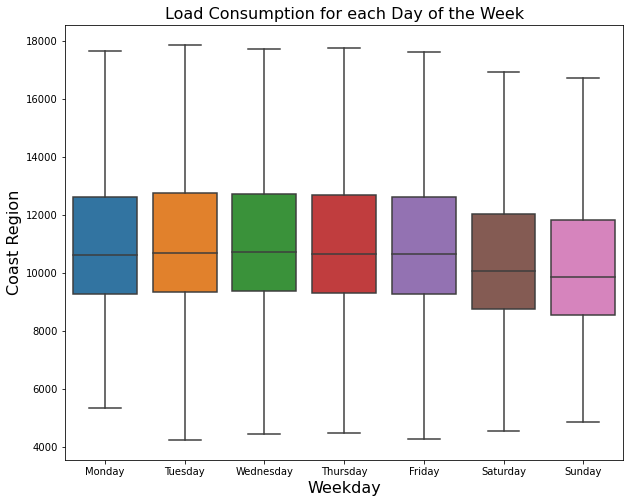

In [86]:
# plot load consumption for each day of the week. Showing only for Coast region 
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(x = hr_load.weekday, y = hr_load.Coast,
            data = hr_load, 
            showfliers = False)
ax.set_xlabel('Weekday', fontsize = 16)
ax.set_ylabel('Coast Region', fontsize = 16)
ax.set_title('Load Consumption for each Day of the Week', fontsize = 16)
plt.show()


Energy consumption is almost constant during weekdays and it decrease slightly on the weekends

## 1.3.3 Load The Weather data

We have two weather information datsets, one is a historic weather data covering 07/01/2008 to 06/19/2021 and the second one is the weather forescast that will be used for prediction for the test set.
The historic weather data has 30 columns. However a number of this columns are redundant, meaning we have two temperature columns one in degree celsius and one in degree fahrenheit, the same redundancy is observed with windspeed, windgust, pressure,etc. Only columns with metric measurements will be imported for this project.
<p>&nbsp;</p>

In [55]:
# Create a list of the column name to import
cols = ['date','time','city','tempC','windspeedKmph','winddirDegree','winddir16Point',\
               'weatherCode','weatherDesc','precipMM','humidity','visibility','pressure',\
               'cloudcover','HeatIndexC','DewPointC','WindChillC',\
               'WindGustKmph','FeelsLikeC','uvIndex']

url = 'https://raw.githubusercontent.com/WiDSTexas2021/datathon-code/main/data/weather_history.csv'
s = requests.get(url).content
weather_hist_raw = pd.read_csv(io.StringIO(s.decode('utf-8')), usecols = cols)

In [56]:
weather_hist_raw.head()

date  time            city  tempC  windspeedKmph  winddirDegree  \
0  2008-07-01     0         Abilene     21              7            173   
1  2008-07-01     0          Austin     25              9            103   
2  2008-07-01     0     Brownsville     26              8            150   
3  2008-07-01     0  Corpus Christi     26             12            146   
4  2008-07-01     0          Dallas     25              9            149   

  winddir16Point  weatherCode           weatherDesc  precipMM  humidity  \
0              S          113                 Clear       0.0        63   
1            ESE          176  Patchy rain possible       0.6        61   
2            SSE          113                 Clear       0.0        86   
3             SE          113                 Clear       0.0        83   
4            SSE          113                 Clear       0.0        46   

   visibility  pressure  cloudcover  HeatIndexC  DewPointC  WindChillC  \
0          10      1018           6          24         14          21   
1           9      1018          17          26         17          25   
2          10      1017           8          29         23          26   
3          10      1017           7          28         23          26   
4          10      1018           4          25         12          25   

   WindGustKmph  FeelsLikeC  uvIndex  
0            15          21        1  
1            18          26        1  
2            14          29        1  
3            21          28        1  
4            18          25        1

In [57]:
weather_hist_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378880 entries, 0 to 378879
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date            378880 non-null  object 
 1   time            378880 non-null  int64  
 2   city            378880 non-null  object 
 3   tempC           378880 non-null  int64  
 4   windspeedKmph   378880 non-null  int64  
 5   winddirDegree   378880 non-null  int64  
 6   winddir16Point  378880 non-null  object 
 7   weatherCode     378880 non-null  int64  
 8   weatherDesc     378880 non-null  object 
 9   precipMM        378880 non-null  float64
 10  humidity        378880 non-null  int64  
 11  visibility      378880 non-null  int64  
 12  pressure        378880 non-null  int64  
 13  cloudcover      378880 non-null  int64  
 14  HeatIndexC      378880 non-null  int64  
 15  DewPointC       378880 non-null  int64  
 16  WindChillC      378880 non-null  int64  
 17  WindGustKm

No null values are observed in the weather data

### 1.3.3.1 Exploring The Weather Data

This section will explore the weather data. 
- From the information above we see that the date and time are in two separate columns. They will be mergeed into one date column, conver to datatime object and finally the date will be passed into the index of the data frame
- Two categorical columns weatherCode and weatherDesc are describing the same information. To avoid redundancy, one of them will be dropped
<p>&nbsp;</p>

In [58]:
# weather_hist_raw.weatherDesc.unique()
n_weatherDesc = len(pd.unique(weather_hist_raw.weatherDesc))
n_weathercode = len(pd.unique(weather_hist_raw.weatherCode))
print(n_weathercode,n_weatherDesc)

45 46


In [59]:
#print(weather_hist_raw.weatherDesc.unique())
print(weather_hist_raw[weather_hist_raw['weatherCode'] == 113]['weatherDesc'].unique())

['Clear' 'Sunny']


The weatherCode and weatherDesc columns are the same information. The weatherDesc is just the interpretation of the weatherCode. From the number of the unique values in each column we see that weatherDesc has one more category. This happend simply because the code 113 is described as 'Clear' and sometimes as 'Sunny'. If we combine these two, we will still endup with a total of 45 categories, which is a bit too much. 

- In the next section of code, we will group the weatherCodes into 7 broader description.
- Create a new columns called weatherCatergory
- Check its values are comparable to the weatherDesc
- After checking the values are consistent, drop the weatherCode and weatherDesc columns

In [60]:
# Weather code meanings came from this website: https://gist.github.com/dawnvoh/a1f513123f7b6a42577d
# the dict mapping was borrowed from wids-datathon-2021-forecasting-electrical-loads_rhinophylla notebook

weather_code = {113: "sunny", 122: "fog",  248: "fog", 260: "fog", 119: "cloudy", 116: "cloudy",  
                386: "light_rain", 353: "light_rain", 296: "light_rain", 293: "light_rain", 176: "light_rain", 143: "light_rain",
                389: "heavy_rain", 359: "heavy_rain", 356: "heavy_rain", 350: "heavy_rain", 308: "heavy_rain", 
                305: "heavy_rain", 302: "heavy_rain", 299: "heavy_rain", 200: "heavy_rain", 
                392: "light_winter_precip", 374: "light_winter_precip", 368: "light_winter_precip", 362: "light_winter_precip", 326: "light_winter_precip",
                323: "light_winter_precip", 317: "light_winter_precip", 311: "light_winter_precip", 281: "light_winter_precip",
                266: "light_winter_precip", 263: "light_winter_precip", 185: "light_winter_precip", 182: "light_winter_precip",
                179: "light_winter_precip", 227: "heavy_winter_precip", 395: "heavy_winter_precip", 377: "heavy_winter_precip", 
                371: "heavy_winter_precip", 365: "heavy_winter_precip", 338: "heavy_winter_precip", 335: "heavy_winter_precip", 
                332: "heavy_winter_precip", 329: "heavy_winter_precip", 320: "heavy_winter_precip", 314: "heavy_winter_precip", 
                284: "heavy_winter_precip", 230: "heavy_winter_precip"}

weather_hist_raw['weatherCategory'] = weather_hist_raw.weatherCode.map(weather_code)
weather_hist_raw.drop(['weatherCode','weatherDesc'], inplace=True, axis=1)

In [61]:
weather_hist_raw.info()
# print(weather_hist_raw.weatherCategory.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378880 entries, 0 to 378879
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   date             378880 non-null  object 
 1   time             378880 non-null  int64  
 2   city             378880 non-null  object 
 3   tempC            378880 non-null  int64  
 4   windspeedKmph    378880 non-null  int64  
 5   winddirDegree    378880 non-null  int64  
 6   winddir16Point   378880 non-null  object 
 7   precipMM         378880 non-null  float64
 8   humidity         378880 non-null  int64  
 9   visibility       378880 non-null  int64  
 10  pressure         378880 non-null  int64  
 11  cloudcover       378880 non-null  int64  
 12  HeatIndexC       378880 non-null  int64  
 13  DewPointC        378880 non-null  int64  
 14  WindChillC       378880 non-null  int64  
 15  WindGustKmph     378880 non-null  int64  
 16  FeelsLikeC       378880 non-null  int6

<p>&nbsp;</p>


Similar to the hourly load data, we will need to convert the date and time into pandas datetime object. for the weather data, the date and time come in a separate columns and we need to create one datetime object containing all the date and time together.

In [62]:
weather_hist_raw.tail()

date  time           city  tempC  windspeedKmph  winddirDegree  \
378875  2021-06-19  2100        Houston     31             12            235   
378876  2021-06-19  2100        Midland     32             21            164   
378877  2021-06-19  2100    San Antonio     33             17            157   
378878  2021-06-19  2100          Tyler     27              5            122   
378879  2021-06-19  2100  Wichita Falls     29             20            139   

       winddir16Point  precipMM  humidity  visibility  pressure  cloudcover  \
378875             SW       0.0        50          10      1009           3   
378876            SSE       0.0        24          10      1005           5   
378877            SSE       0.0        46          10      1008           5   
378878            ESE       0.0        77          10      1009          44   
378879             SE       0.0        48          10      1007           1   

        HeatIndexC  DewPointC  WindChillC  WindGustKmph  FeelsLikeC  uvIndex  \
378875          34         20          31            15          34        1   
378876          31          9          32            34          31        1   
378877          36         16          33            27          36        1   
378878          29         22          27             9          29        1   
378879          31         15          29            37          31        1   

       weatherCategory  
378875          cloudy  
378876          cloudy  
378877          cloudy  
378878      light_rain  
378879           sunny

In [63]:
# Combining the date and time into one column
# first convert the time column from int to a string and then fill it to 4 decimal places
weather_hist_raw['Date'] = weather_hist_raw['date'] + ' ' +  weather_hist_raw['time'].astype(str).str.zfill(4)
weather_hist_raw['Date'] = pd.to_datetime(weather_hist_raw['Date'])
weather_hist_raw.set_index('Date', inplace=True)
weather_hist_raw.drop(['date','time'], axis=1, inplace=True)

In [64]:
weather_hist_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 378880 entries, 2008-07-01 00:00:00 to 2021-06-19 21:00:00
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   city             378880 non-null  object 
 1   tempC            378880 non-null  int64  
 2   windspeedKmph    378880 non-null  int64  
 3   winddirDegree    378880 non-null  int64  
 4   winddir16Point   378880 non-null  object 
 5   precipMM         378880 non-null  float64
 6   humidity         378880 non-null  int64  
 7   visibility       378880 non-null  int64  
 8   pressure         378880 non-null  int64  
 9   cloudcover       378880 non-null  int64  
 10  HeatIndexC       378880 non-null  int64  
 11  DewPointC        378880 non-null  int64  
 12  WindChillC       378880 non-null  int64  
 13  WindGustKmph     378880 non-null  int64  
 14  FeelsLikeC       378880 non-null  int64  
 15  uvIndex          378880 non-null  int64  
 16  weat

In [65]:
weather_hist_raw.describe()

tempC  windspeedKmph  winddirDegree       precipMM  \
count  378880.000000  378880.000000  378880.000000  378880.000000   
mean       20.429743      15.072904     159.974287       0.387574   
std         8.926307       7.541821      85.396612       1.740827   
min       -21.000000       0.000000       0.000000       0.000000   
25%        14.000000       9.000000     110.000000       0.000000   
50%        22.000000      14.000000     159.000000       0.000000   
75%        27.000000      19.000000     196.000000       0.000000   
max        45.000000      80.000000     360.000000     127.900000   

            humidity    visibility       pressure     cloudcover  \
count  378880.000000  378880.00000  378880.000000  378880.000000   
mean       64.973818       9.31459    1015.731551      30.364421   
std        21.180240       1.99402       6.366372      32.758268   
min         1.000000       0.00000     985.000000       0.000000   
25%        49.000000      10.00000    1012.000000       4.000000   
50%        67.000000      10.00000    1015.000000      16.000000   
75%        83.000000      10.00000    1019.000000      51.000000   
max       100.000000      10.00000    1049.000000     100.000000   

          HeatIndexC      DewPointC     WindChillC   WindGustKmph  \
count  378880.000000  378880.000000  378880.000000  378880.000000   
mean       21.613875      12.627373      19.836919      22.678632   
std         9.939506       9.266707       9.905093      11.068895   
min       -21.000000     -52.000000     -29.000000       0.000000   
25%        14.000000       6.000000      13.000000      15.000000   
50%        24.000000      15.000000      22.000000      21.000000   
75%        29.000000      20.000000      27.000000      29.000000   
max        59.000000      29.000000      45.000000     114.000000   

          FeelsLikeC        uvIndex  
count  378880.000000  378880.000000  
mean       20.903077       3.224628  
std        10.883233       2.605011  
min       -29.000000       1.000000  
25%        13.000000       1.000000  
50%        22.000000       1.000000  
75%        29.000000       6.000000  
max        59.000000      10.000000

### 1.3.3.2 Data Visualization

In this section we will explore some the weather data visually. We will see some distribution and correlation heatmap

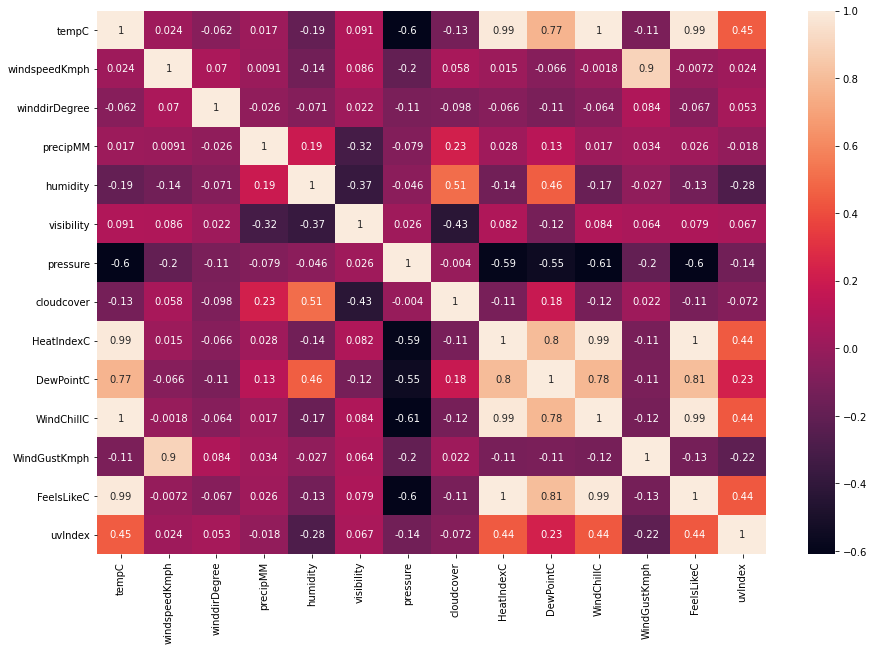

In [84]:
# plotting heatmap
fig,ax = plt.subplots(figsize=(15,10))
sns.heatmap(weather_hist_raw.corr(), annot = True, ax = ax)
plt.show()

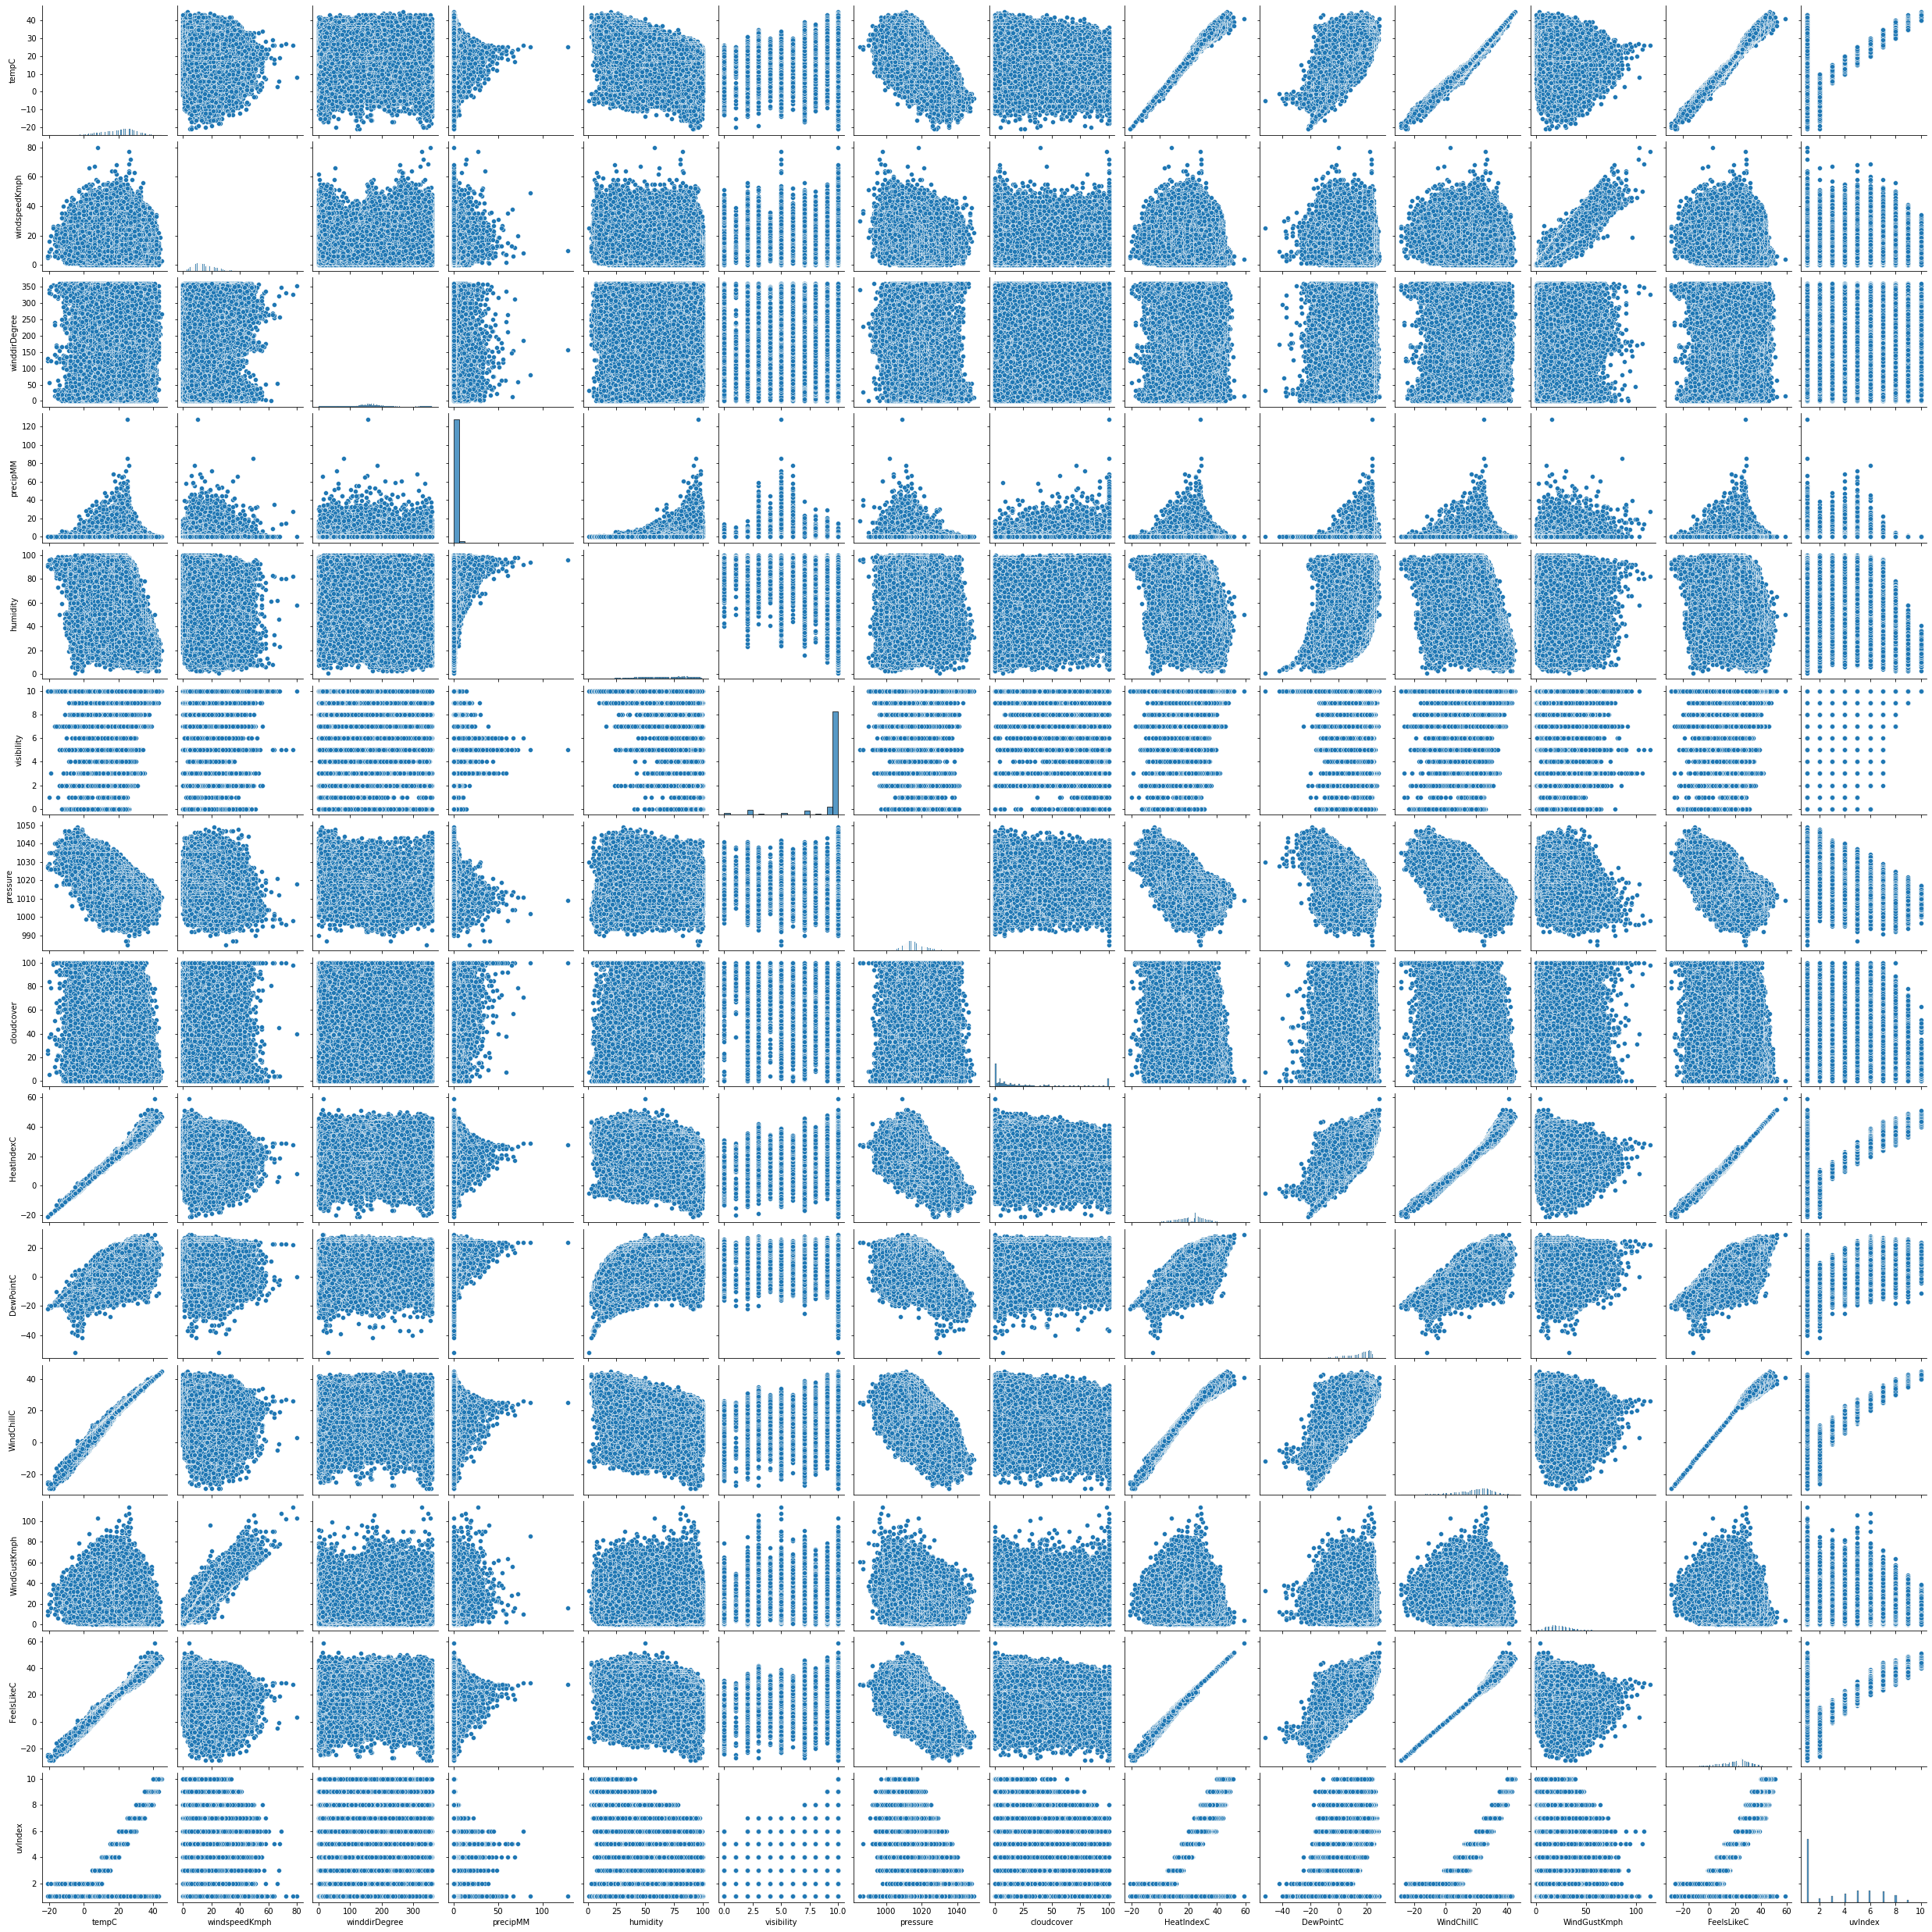

In [85]:
# Exploring pairplots
sns.pairplot(weather_hist_raw)
plt.show()

The heat map and the pairplots show that several features in the weather data are higly correlated with each other. However, this is not completely a surprise. 
    - Temperature has a correlation of 0.99 with 'Feelslike' and 'HeatIndex' and it has a perefect correlation of 1 with windchill
    - Wind speed is also higly correlated (corr. coefficient of 0.9) with WindGust
    
The above heatmap does indicate there is redundant information in our weather feature and some of them can be dropped. We will keep all the features in data-wrangling notebook and we will drop them in the EDA part.


    

### 1.3.3.3 Selecting One City For Each Zone


There are 10 cities in the weather data corresponding to the 8 weather zones. Six of the zones have one large city from the weather data corresponding to them. However, the South and South Central zones have two cities each in the weather data. We need to select one city going forward.

We have seen that the electric load is directly proportional to the population size and as such it would be reasonable to select the city with larger population to represent the zone. Population size of each city in texas can obtained from this site https://www.texas-demographics.com/cities_by_population. 
- South Central zone --- San Antonio = 1,508,083 Austin = 950,807
- South Zone --- Corpus Christi = 325,780  Brownsville = 182271

San Antonio and Corpus Christi are the two most populos cities in each of their respective zone and thus going forward, we will use the weather information of San Antonio and Corpus Christi for the South Central and South zones respectively.

In [68]:
weather_hist_raw.shape

(378880, 17)

In [69]:
# drop Austin and Brownsville rows from the weather dataframe
weather_hist_cleaned = weather_hist_raw[(weather_hist_raw['city'] != 'Austin') & (weather_hist_raw['city'] != 'Brownsville')]
weather_hist_cleaned.shape

(303104, 17)

## 1.3.4 Load The Covid19 Datasets

We will load Texas Covid19 related datasets in the section below. Two files containing Covid19 confirmed case and Covid19 related deaths are provided. The datasets contains all Texas counties, however we need only the counties where the eight major cities in our weather zone are located.
<p>&nbsp;</p>

In [70]:
# Loading Covid19 confirmed.
#cities = ["Abilene","Corpus Christi","Dallas","Houston","Midland","San Antonio","Tyler","Wichita Falls"]
county = ["Date","Taylor","Nueces","Dallas","Harris","Midland","Bexar","Smith","Wichita"]

url = 'https://raw.githubusercontent.com/WiDSTexas2021/datathon-code/main/data/texas_covid_confirmed.csv'
s = requests.get(url).content
covid_confirmed = pd.read_csv(io.StringIO(s.decode('utf-8')), usecols=county)

In [71]:
covid_confirmed.tail()

Date   Bexar  Dallas  Harris  Midland  Nueces  Smith  Taylor  \
510  2021-06-15  224667  304903  403496    17761   43718  20607   15877   
511  2021-06-16  225547  305015  403496    17765   43737  20607   15886   
512  2021-06-17  225547  305118  403151    17772   43754  20607   15890   
513  2021-06-18  225547  305298  402916    17774   43805  20645   15892   
514  2021-06-19  225547  305400  403069    17776   43805  20645   15896   

     Wichita  
510    15170  
511    15170  
512    15170  
513    15170  
514    15196

In [72]:
covid_confirmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     515 non-null    object
 1   Bexar    515 non-null    int64 
 2   Dallas   515 non-null    int64 
 3   Harris   515 non-null    int64 
 4   Midland  515 non-null    int64 
 5   Nueces   515 non-null    int64 
 6   Smith    515 non-null    int64 
 7   Taylor   515 non-null    int64 
 8   Wichita  515 non-null    int64 
dtypes: int64(8), object(1)
memory usage: 36.3+ KB


In [73]:
# Convert the Date to datetime object and set index to date 
covid_confirmed['Date'] = pd.to_datetime(covid_confirmed['Date'])
covid_confirmed.set_index('Date', inplace=True)

In [74]:
covid_confirmed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 515 entries, 2020-01-22 to 2021-06-19
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Bexar    515 non-null    int64
 1   Dallas   515 non-null    int64
 2   Harris   515 non-null    int64
 3   Midland  515 non-null    int64
 4   Nueces   515 non-null    int64
 5   Smith    515 non-null    int64
 6   Taylor   515 non-null    int64
 7   Wichita  515 non-null    int64
dtypes: int64(8)
memory usage: 36.2 KB


In [108]:
# Loading Covid19 deaths.
county = ["Date","Taylor","Nueces","Dallas","Harris","Midland","Bexar","Smith","Wichita"]

url = 'https://raw.githubusercontent.com/WiDSTexas2021/datathon-code/main/data/texas_covid_deaths.csv'
s = requests.get(url).content
covid_deaths = pd.read_csv(io.StringIO(s.decode('utf-8')), usecols=county)

In [109]:
covid_deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     515 non-null    object
 1   Bexar    515 non-null    int64 
 2   Dallas   515 non-null    int64 
 3   Harris   515 non-null    int64 
 4   Midland  515 non-null    int64 
 5   Nueces   515 non-null    int64 
 6   Smith    515 non-null    int64 
 7   Taylor   515 non-null    int64 
 8   Wichita  515 non-null    int64 
dtypes: int64(8), object(1)
memory usage: 36.3+ KB


In [110]:
# Convert the Date to datetime object and set index to date 
covid_deaths['Date'] = pd.to_datetime(covid_deaths['Date'])
covid_deaths.set_index('Date', inplace=True)
covid_deaths

Bexar  Dallas  Harris  Midland  Nueces  Smith  Taylor  Wichita
Date                                                                      
2020-01-22      0       0       0        0       0      0       0        0
2020-01-23      0       0       0        0       0      0       0        0
2020-01-24      0       0       0        0       0      0       0        0
2020-01-25      0       0       0        0       0      0       0        0
2020-01-26      0       0       0        0       0      0       0        0
...           ...     ...     ...      ...     ...    ...     ...      ...
2021-06-15   3600    4099    6518      272     837    485     413      379
2021-06-16   3605    4103    6525      272     837    485     413      379
2021-06-17   3608    4106    6534      272     837    486     413      380
2021-06-18   3610    4109    6540      272     838    486     414      380
2021-06-19   3611    4110    6545      272     838    486     414      381

[515 rows x 8 columns]

### 1.3.4.1 Renaming and Merging Covid19 Datasets
- Rename the column names in both the covid datasets from county name to their corresponding city names. This will make joining the covid data to the weather and load dataframes easier

In [111]:
# Rename the columns names 
cities = ["San Antonio","Dallas","Houston","Midland","Corpus Christi","Tyler","Abilene","Wichita Falls"]
covid_confirmed.columns = cities
covid_deaths.columns = cities

In [112]:
covid_deaths

San Antonio  Dallas  Houston  Midland  Corpus Christi  Tyler  \
Date                                                                       
2020-01-22            0       0        0        0               0      0   
2020-01-23            0       0        0        0               0      0   
2020-01-24            0       0        0        0               0      0   
2020-01-25            0       0        0        0               0      0   
2020-01-26            0       0        0        0               0      0   
...                 ...     ...      ...      ...             ...    ...   
2021-06-15         3600    4099     6518      272             837    485   
2021-06-16         3605    4103     6525      272             837    485   
2021-06-17         3608    4106     6534      272             837    486   
2021-06-18         3610    4109     6540      272             838    486   
2021-06-19         3611    4110     6545      272             838    486   

            Abilene  Wichita Falls  
Date                                
2020-01-22        0              0  
2020-01-23        0              0  
2020-01-24        0              0  
2020-01-25        0              0  
2020-01-26        0              0  
...             ...            ...  
2021-06-15      413            379  
2021-06-16      413            379  
2021-06-17      413            380  
2021-06-18      414            380  
2021-06-19      414            381  

[515 rows x 8 columns]

In [120]:
covid19_deaths = pd.melt(covid_deaths.reset_index(), id_vars = 'Date', var_name=['region'], value_name = 'covid_deaths')
covid19_deaths
covid19_confirmed = pd.melt(covid_confirmed.reset_index(), id_vars = 'Date', var_name=['region'], value_name = 'covid_confirmed')
covid19_confirmed

Date         region  covid_confirmed
0    2020-01-22    San Antonio                0
1    2020-01-23    San Antonio                0
2    2020-01-24    San Antonio                0
3    2020-01-25    San Antonio                0
4    2020-01-26    San Antonio                0
...         ...            ...              ...
4115 2021-06-15  Wichita Falls            15170
4116 2021-06-16  Wichita Falls            15170
4117 2021-06-17  Wichita Falls            15170
4118 2021-06-18  Wichita Falls            15170
4119 2021-06-19  Wichita Falls            15196

[4120 rows x 3 columns]

In [121]:
covid19_deaths.set_index('Date', inplace=True)
covid19_confirmed.set_index('Date', inplace=True)

In [122]:
covid19_deaths.head(24)
covid19_confirmed.head(24)

region  covid_confirmed
Date                                    
2020-01-22  San Antonio                0
2020-01-23  San Antonio                0
2020-01-24  San Antonio                0
2020-01-25  San Antonio                0
2020-01-26  San Antonio                0
2020-01-27  San Antonio                0
2020-01-28  San Antonio                0
2020-01-29  San Antonio                0
2020-01-30  San Antonio                0
2020-01-31  San Antonio                0
2020-02-01  San Antonio                0
2020-02-02  San Antonio                0
2020-02-03  San Antonio                0
2020-02-04  San Antonio                0
2020-02-05  San Antonio                0
2020-02-06  San Antonio                0
2020-02-07  San Antonio                0
2020-02-08  San Antonio                0
2020-02-09  San Antonio                0
2020-02-10  San Antonio                0
2020-02-11  San Antonio                0
2020-02-12  San Antonio                0
2020-02-13  San Antonio                0
2020-02-14  San Antonio                0

In [123]:
covid19_deaths.sort_index()
covid19_confirmed.sort_index()

region  covid_confirmed
Date                                       
2020-01-22     San Antonio                0
2020-01-22         Abilene                0
2020-01-22           Tyler                0
2020-01-22  Corpus Christi                0
2020-01-22         Midland                0
...                    ...              ...
2021-06-19         Houston           403069
2021-06-19          Dallas           305400
2021-06-19     San Antonio           225547
2021-06-19         Abilene            15896
2021-06-19   Wichita Falls            15196

[4120 rows x 2 columns]

In [144]:
covid19_deaths.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4120 entries, 2020-01-22 to 2021-06-19
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   region        4120 non-null   object
 1   covid_deaths  4120 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 256.6+ KB


In [145]:
covid19_confirmed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4120 entries, 2020-01-22 to 2021-06-19
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   region           4120 non-null   object
 1   covid_confirmed  4120 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 256.6+ KB


In [157]:
# covid19_combined = pd.merge(covid19_confirmed,covid19_deaths, how='outer', left_index=True, right_index=True,
# suffixes=['_confirmed','_death'])
covid19_combined = pd.concat([covid19_confirmed,covid19_deaths], axis =1, join = 'inner') #, suffix =['_confirmed','_death'])
covid19_combined = covid19_combined.T.drop_duplicates().T # this removes the duplicated region column
covid19_combined.sort_index().tail() 

region covid_confirmed covid_deaths
Date                                                  
2021-06-19        Houston          403069         6545
2021-06-19         Dallas          305400         4110
2021-06-19    San Antonio          225547         3611
2021-06-19        Abilene           15896          414
2021-06-19  Wichita Falls           15196          381

<p>&nbsp;</p>

- The covid data only starts from 2020-01-22 (obviously there won't be data as the disease did not exist before that time). We will have to see how this information would be helpful for our forecasting problem, as it only covers a very tiny segment of time series data.

### 1.3.5  Saving Cleaned Data
Each modified dataset (the electric load, the weather data and the combined Covid19 data) will be saved to be used in the next step of Exploratory Data Analysis (EDA) part
<p>&nbsp;</p>

In [81]:
# save the hourly load data to a new csv file
hr_load.to_csv('./modified_data/ercot_hourly_cleaned.csv',date_format='%Y-%m-%d %H:%M:%S')

In [82]:
# Save the cleaned weather data to a new csv file
weather_hist_raw.to_csv('./modified_data/weather_hist_all_cities_cleaned.csv',date_format='%Y-%m-%d %H:%M:%S')
weather_hist_cleaned.to_csv('./modified_data/weather_hist_cleaned.csv',date_format='%Y-%m-%d %H:%M:%S')

In [158]:
# save the combined covid data to a new csv file
covid19_combined.to_csv('./modified_data/texas_combined_covid19.csv',date_format='%Y-%m-%d %H:%M:%S')

### 1.3.6  Summary

#### Hourly Electric load

- The electric load is an hourly frequency data showing energy consumption for each Texas weather zone in MegaWatt(MW) starting from 01-01-2005 up to 06-19-2021
- Out of the 144335 raws only one missing values is identified and was filled using bfill
- From the summary statistics and visualization we can see that, by far the North Central and the Coast zones account the majority of the electric load demand, followed by the South Central and South zones. This is not surprising, as the North Central and the Coast have the two largest metropolitan areas of Dallas-Fort Worth and Houston respectively. South West zone also includes the cities of Austin and San-Antonio.
- This summary statistics shows, the electric load demand is proportional to the population size.
- The electric load demand shows strong seasonality (yearly, monthly as well as daily) in all zones.
- There is a strong upward trend in the farwest zone. This strong upward trend is not observed in the other zones(eventough a very small upward trend can be infered)
- Several features have been extracted including:
    - Features such as weekdays,month,year were extracted from the datetime stamp in the data
    - A category classifying each day as a working or non-working day
    - A column indicating if a given day is a holiday or not (based on the US government holiday calander)
- Energy consumption is almost constant during weekdays and it decrease slightly on the weekends   



#### Weather Data

- Only relevant columns were load from the raw csv file. Columns with redundant information, such as temperature_in_C and temperature_in_F ae the same information, hence we load only one of them
- No missing data is observed. 
- The weatherCode and weatherDesc columns contain the same information. The weatherDesc is just the interpretation of the weatherCode and each has 45 unique categories, which was a bit too much. A new weather category column was created and the weather codes were grouped into 7 broader category description. Both the weatherCode and weatherDesc were discarded
- The date information was converted into pandas datetime object
- The heatmap and the pairplots show that there is some collinearity between certain features. For example, temperature has a correlation of 0.99 with 'Feelslike' and 'HeatIndex' and it has a perefect correlation of 1 with windchill - Wind speed is also higly correlated (corr. coefficient of 0.9) with WindGust. This indicates there is redundant information in our weather feature and some of them can be dropped. We will keep all the features in data-wrangling notebook and we will drop them in the EDA part.
- There were 10 cities in the weather data corresponding to the 8 weather zones. We selected one city per each weather zone. The South and South Central zones have two cities each in the weather data. Population size was used to select the city for these two zones. San Antonio and Corpus Christi are the two most populos cities in each of their respective zone and thus were selected to represent the South Central and South zones respectively.

#### Covid19 data

- the two covid19 related datasets were read and merged together. The data has a daily deaths and confirmed cases beggining 01-22-2020. We will have to see how this information would be helpful for our forecasting problem, as it only covers a very tiny segment of time series data. 
